In [17]:
from stpy.kernels import KernelFunction
from stpy.borel_set import BorelSet,HierarchicalBorelSets
from stpy.point_processes.poisson_rate_estimator import PoissonRateEstimator
import torch 
import pandas as pd
import geopandas
import numpy as np 
import matplotlib.pyplot as plt
import contextily as ctx
from scipy.interpolate import griddata
from stpy.point_processes.poisson.poisson import PoissonPointProcess
from sensepy.capture_thompson import CaptureThompson
import time
from utils import *

In [18]:
estimator = PoissonRateEstimator(
    HierarchicalBorelSets(
        d=2, interval=[(-1, 1), (-1, 1)], levels=8
    ),  # 4^(8-1) cells in the lowest level
    d=2,
    kernel=KernelFunction(kernel_name="squared_exponential", gamma=0.12, d=2),
    max_intensity=10.0e10,  # maximal value of the rate function
    min_intensity=0.1,  # minimal value of the rate function
    basis_size_per_dim=10,  # number of basis functions along each axis
    jitter=10e-3,
    langevine_sampling_steps=200,  # langevin steps for sampling
    optimization_library="cvxpy",
)
Num_data_points = 200
name = "./sensepy/sensepy/benchmarks/data/taxi_data.csv"
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1., 1.], [-1, 1]]).double())

Precomputing phis.
Precomputation finished.


In [19]:
name = "sensepy/sensepy/benchmarks/data/taxi_data.csv"
# borel set a square with boundaries [-1,1]^2
D = BorelSet(2, bounds=torch.Tensor([[-1.0, 1.0], [-1, 1]]).double())
data, gdf = get_taxi_data(200, D)

In [20]:
# load data in the above format
st = time.process_time()
estimator.load_data(data)
et = time.process_time()
print("Time to load data: ", et-st)

Time to load data:  4.375653


In [21]:
# fit the Cox process by calculating MAP. Method is defined by estimator.estimator
# it is set to penalized_likelihood, so we do the posterior GP approximation by
# the sensing paper. Also estimator.feedback is set to count-record so no histogram
# By default dual = True which means that data is split into buckets that
# are given by the quadtree
estimator.dual = True
st = time.process_time()
estimator.fit_gp()
et = time.process_time()
print("Time to fit GP: ", et-st)

                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Oct 11 04:00:05 PM: Your problem has 100 variables, 200 constraints, and 0 parameters.
(CVXPY) Oct 11 04:00:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 11 04:00:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 11 04:00:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Oct 11 04:00:05 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 11 04:00:05 PM: Compiling problem (target solver=CLARABEL

(CVXPY) Oct 11 04:00:05 PM: Applying reduction CLARABEL
(CVXPY) Oct 11 04:00:05 PM: Finished problem compilation (took 1.658e-01 seconds).
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
(CVXPY) Oct 11 04:00:05 PM: Invoking solver CLARABEL  to obtain a solution.
-------------------------------------------------------------
           Clarabel.rs v0.9.0  -  Clever Acronym                

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 215
  constraints   = 545
  nnz(P)        = 100
  nnz(A)        = 31615
  cones (total) = 116
    : Nonnegative = 1,  numel = 200
    : Exponential = 115,  numel = (3,3,3,3,...,3)

settings:
  linear alg

/home/paul/semesterprojekt/.env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [22]:

theta = torch.full(size=(estimator.get_m(), 1), fill_value=1.0).view(-1).double()
_, invGamma_half = estimator.cov(inverse=True)
matrix = estimator.observations @ invGamma_half @ theta

In [23]:
# Fit the approximation to the posterior using L-BFGS-B

from autograd_minimize import minimize

l, Lambda, u = estimator.get_constraints()
_, invGamma_half = estimator.cov(inverse=True)

eps = 1e-4
theta0 = torch.full(size=(estimator.get_m(), 1), fill_value=1.0).view(-1).double()

# Move to gpu
theta0 = theta0.cuda()
estimator.phis = estimator.phis.cuda()
estimator.observations = estimator.observations.cuda()
invGamma_half = invGamma_half.cuda()
l = l.cuda()
u = u.cuda()

def objective(theta):
    return -torch.sum(torch.log(estimator.observations @ invGamma_half @ theta + 1e-7)) + torch.sum(
        estimator.phis @ invGamma_half @ theta) + estimator.s * 0.5 * torch.sum((invGamma_half @ theta) ** 2)

res = minimize(objective, theta0.cpu().detach().numpy(), backend='torch', method='L-BFGS-B',
                    bounds=(l[0] + eps, u[0]), precision='float64', tol=1e-8,
                    options={'ftol': 1e-08,
                                'gtol': 1e-08, 'eps': 1e-08,
                                'maxfun': 15000, 'maxiter': 15000,
                                'maxls': 20}, torch_device=str(theta0.device))

estimator.rate = invGamma_half @ torch.from_numpy(res.x).cuda()



In [24]:
# Move back to cpu
estimator.phis = estimator.phis.cpu()
estimator.observations = estimator.observations.cpu()
estimator.rate = estimator.rate.cpu()

In [25]:
left, down, right, up = gdf.total_bounds

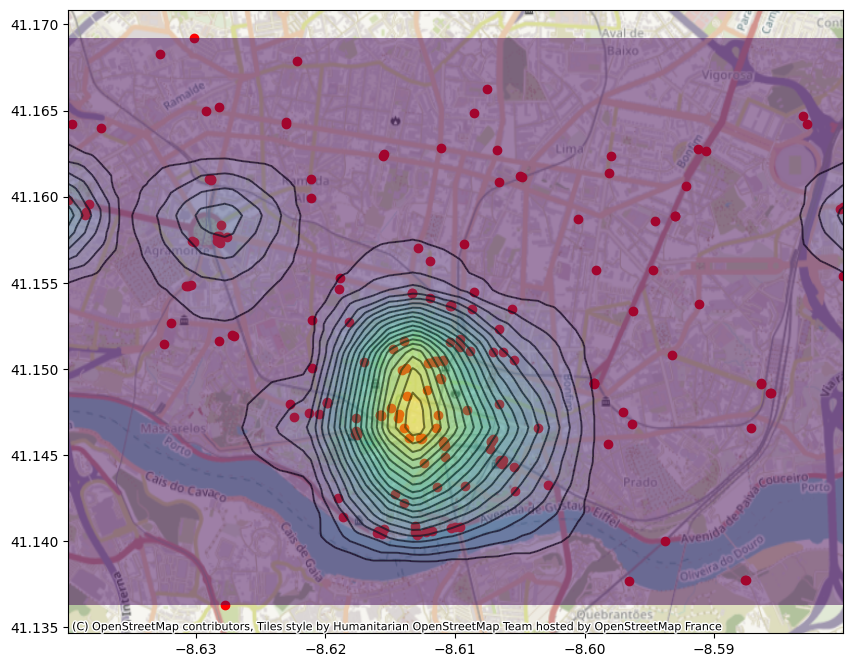

In [26]:
# Plotting the fitted Map 
# get min and max longitude from gdf

n = 30 # discretization
xtest = D.return_discretization(n)
Map = BorelSet(d=2, bounds=torch.Tensor([[left, right], [down, up]]).double())
xtest_orig = Map.return_discretization(n).numpy()

f = estimator.rate_value(xtest)

xx = xtest_orig[:, 0]
yy = xtest_orig[:, 1]

grid_x, grid_y = np.mgrid[min(xx):max(xx):100j, min(yy):max(yy):100j]
grid_z_f = griddata((xx, yy), f[:, 0].detach().numpy(), (grid_x, grid_y), method='linear')

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color='red', figsize=(10, 10))
cs = ax.contourf(grid_x, grid_y, grid_z_f, levels=20, alpha=0.5)
ax.contour(cs, colors='k', alpha=0.5)
ctx.add_basemap(ax, crs=gdf.crs.to_string())
plt.show()